# Get The Data & Prepare The Files
Here we fetch the data and make the files for the labels/images for training/testing, we also make a folder for the model checkpoints to save the progress while training.
Our data consists of 49998 images, the name of each image matches the word written on the image
[Link To Download The Data From](https://data.mendeley.com/datasets/gfc32vndz8/2).
After downloading the Synthetic Arabic dataset.zip File, Upload it to your google drive.

In [1]:
import os
from torchvision import transforms
import cv2
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.nn import CTCLoss
import csv
import shutil
import glob
import pandas as pd
from torch.utils.data import Dataset
from scipy import signal
from scipy.io import wavfile
from PIL import Image
import numpy as np
from PIL import ImageOps
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab.patches import cv2_imshow
import random


In [3]:
#Connect google colab to google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Mounted at /content/gdrive


In [4]:
!unzip /content/gdrive/MyDrive/SyntheticArabicdataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: out/آليكس_49958.jpg  
  inflating: out/الاختيارات_49963.jpg  
  inflating: out/التدوير_40.jpg  
  inflating: out/الإدارية_45.jpg  
  inflating: out/وينتهي_51.jpg  
  inflating: out/بواجبه_241.jpg  
  inflating: out/تشرشل_348.jpg  
  inflating: out/يتصرف_362.jpg  
  inflating: out/للمقاطعة_374.jpg  
  inflating: out/الحيتان_409.jpg  
  inflating: out/نقاش_412.jpg    
  inflating: out/أرسلوها_504.jpg  
  inflating: out/الصبغة_575.jpg  
  inflating: out/نفوت_579.jpg    
  inflating: out/دائمآ_600.jpg  
  inflating: out/رجلى_705.jpg    
  inflating: out/الأدرينالين_789.jpg  
  inflating: out/أمضي_866.jpg    
  inflating: out/اللثة_963.jpg  
  inflating: out/أنانيا_1000.jpg  
  inflating: out/للدعم_1090.jpg  
  inflating: out/ظهرك_1139.jpg   
  inflating: out/تضاجعني_1209.jpg  
  inflating: out/ظهرى_1279.jpg   
  inflating: out/متدين_1283.jpg  
  inflating: out/توثيق_1371.jpg  
  inflating: out/هجرة_1422.jpg   
  inflating: out

In [5]:
#Augmentaion

# elastic_transformer = v2.ElasticTransform(alpha=random.randint(60, 151))
# files = os.listdir('/content/out')
# for filename in files:
#   img_path = os.path.join('/content/out', filename)
#   img = Image.open(img_path)

  # img_width, img_height = img.size
  # new_img = Image.new(img.mode, (img_width+img_width//2, img_height+img_height//2), (255, 0, 255))
  # img_width, img_height = new_img.size
  # new_img.paste(img, (img_width//8, img_height//8))

  # new_filename = filename
  # for i in range(len(filename)):
  #     if(filename[i].isdigit()):
  #        new_filename = filename[:i+1] + ';' + filename[i+1:]
  #        break
  # new_path = os.path.join('/content/out', new_filename)
  # new_img.save(new_path)
  # try:
  #   # Code that might raise an error
  #   augmented = elastic_transformer(img)
  #   new_filename = filename
  #   for i in range(len(filename)):
  #     if(filename[i].isdigit()):
  #        new_filename = filename[:i+1] + '*' + filename[i+1:]
  #        break
  #   output_path = os.path.join('/content/out', new_filename)
  #   augmented = np.array(augmented)
  #   cv2.imwrite(output_path, augmented)
  # except Exception as e:
  #     print("An error occurred:", e)
  #     # Skip the remaining code
  #     pass

#Here we set up the data files and put the paths along with the labels in a csv file, also we put the images in their corresponding folders
number_of_training_samples = 45000
number_of_testing_samples = 4000
#arabic letters only
letters = ['ھ', 'ا', 'إ', 'أ', 'آ', 'لأ', 'لإ', 'لآ', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'ع', 'غ', 'ط', 'ظ', 'ئ', 'س', 'ش', 'ص', 'ض', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ي', 'لا', 'ء', 'ى', 'ة', 'ؤ', 'ئ']
#arabic letters + numbers
alphabet = ['ھ', 'ا', 'إ', 'أ', 'آ', 'لأ', 'لإ', 'لآ', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'ع', 'غ', 'ط', 'ظ', 'ئ', 'س', 'ش', 'ص', 'ض', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ي', 'لا', 'ء', 'ى', 'ة', 'ؤ', 'ئ', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '١', '٢', '٣', '٤', '٥', '٦', '٧', '٨', '٩', '٠']

all_images = os.listdir('/content/out')#The whole dataset
all_images.remove('ט_16066.jpg')
# all_images.remove('ט_1*6066.jpg')
# all_images.remove('ט_1;6066.jpg')
all_images = np.random.choice(all_images, size=len(all_images), replace=False)
images = all_images[ :number_of_testing_samples + number_of_training_samples]# We only want a portion of the dataset, not all of it
labels = [(file_name, ''.join([x for x in file_name if x in letters])) for file_name in images] #Extracting the correct image label from the image name

#Preparing the files of the training and testing images and labels
old_dir_path = '/content/out'
new_dir_path = '/content'

os.makedirs('/content/train_images', exist_ok=True)
os.makedirs('/content/test_images', exist_ok=True)

f1 = '/content/train_images'
train_images = images[:number_of_training_samples]
for img in train_images:
    file_path = os.path.join(old_dir_path, img)
    new_file_path = os.path.join(f1, img)
    shutil.copy(file_path, new_file_path)

f2 = '/content/train_labels.csv'
train_labels = labels[:number_of_training_samples]
for i, pair in enumerate(train_labels):
    train_labels[i] = (os.path.join(f1, pair[0]), pair[1])
with open(f2, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['Image Path', 'Label'])
    for row in train_labels:
        writer.writerow(row)

f3 = '/content/test_images'
test_images = images[number_of_training_samples: ]
for img in test_images:
    file_path = os.path.join(old_dir_path, img)
    new_file_path = os.path.join(f3, img)
    shutil.copy(file_path, new_file_path)

f4 = '/content/test_labels.csv'
test_labels = labels[number_of_training_samples :]
for i, pair in enumerate(test_labels):
    test_labels[i] = (os.path.join(f3, pair[0]), pair[1])
with open(f4, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['Image Path', 'Label'])
    for row in test_labels:
        writer.writerow(row)
os.makedirs('/content/checkpoints', exist_ok=True)


#Hyperparameters Configurations
You can try with different value for learning rate and batch size


In [6]:
#We have the configration for the hyperparameters

common_config = {
    'data_dir': 'data/mnt/ramdisk/max/90kDICT32px/',
    'img_width': 100,
    'img_height': 32,
    'map_to_seq_hidden': 64,
    'rnn_hidden': 256,
    'leaky_relu': False,
}

train_config = {
    'epochs': 200,
    'train_batch_size': 32,
    'eval_batch_size': 64,
    'lr': 0.001,
    'show_interval': 100,
    'valid_interval': 2000,
    'save_interval': 2000,
    'cpu_workers': 4,
    'reload_checkpoint': None,
    'valid_max_iter': 100,
    'decode_method': 'greedy',
    'beam_size': 10,
    'checkpoints_dir': '/content/checkpoints/'
}
train_config.update(common_config)

evaluate_config = {
    'eval_batch_size': 256,
    'cpu_workers': 4,
    'reload_checkpoint': '/content/checkpoints/crnn_124000_loss191.6488047976893.pt',
    'decode_method': 'beam_search',
    'beam_size': 10,
}
evaluate_config.update(common_config)
config2 = {
    "train_imgs": "train_images",
    "test_imgs": "test_images",
    "train_labels": "train_labels.csv",
    "test_labels": "test_labels.csv"
}

# Data Set Custom Class

In [7]:
 #We take a look at the data we got
 data = pd.read_csv('/content/test_labels.csv')
 data

,Image Path,Label
0,/content/test_images/أمد_1*6866.jpg,أمد
1,/content/test_images/منتجات_3*7322.jpg,منتجات
2,/content/test_images/سرت_3079.jpg,سرت
3,/content/test_images/توخى_1*2195.jpg,توخى
4,/content/test_images/لقناة_1*7766.jpg,لقناة
...,...,...
7995,/content/test_images/لإنقاذنا_27307.jpg,لإنقاذنا
7996,/content/test_images/لوبيز_9*846.jpg,لوبيز
7997,/content/test_images/أستمعت_23277.jpg,أستمعت
7998,/content/test_images/السحب_29181.jpg,السحب


In [7]:
class Synth90kDataset(Dataset):
    CHARS = ['ھ', 'ا', 'إ', 'أ', 'آ', 'لأ', 'لإ', 'لآ', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'ع', 'غ', 'ط', 'ظ', 'ئ', 'س', 'ش', 'ص', 'ض', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ي', 'لا', 'ء', 'ى', 'ة', 'ؤ', 'ئ', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '١', '٢', '٣', '٤', '٥', '٦', '٧', '٨', '٩', '٠']
    CHAR2LABEL = {char: i + 1 for i, char in enumerate(CHARS)}
    LABEL2CHAR = {label: char for char, label in CHAR2LABEL.items()}

    def __init__(self, train = True, img_height=32, img_width=100):
        self.data = pd.read_csv(config2['train_labels']) if train else pd.read_csv(config2['test_labels'])
        self.paths = self.data['Image Path']
        self.labels = self.data['Label']
        self.img_height = img_height
        self.img_width = img_width
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):#Here we get the image and the label, we apply tranformation and we turn them into Tensors as preparation for the model
        #Get the image
        path = self.paths.iloc[index]
        image = Image.open(path).convert('L')

        #Applying the correct tranformation to the image
        image = image.resize((self.img_width, self.img_height), resample=Image.BILINEAR)
        image = np.array(image)
        image = image.reshape((1, self.img_height, self.img_width))
        image = (image / 127.5) - 1.0

        image = torch.FloatTensor(image)

        label = self.labels.iloc[index]#The original label text
        target = [self.CHAR2LABEL[c] for c in label]#Applying the correct Transformation
        target_length = [len(target)]

        target = torch.LongTensor(target)
        target_length = torch.LongTensor(target_length)
        return image, target, target_length

def synth90k_collate_fn(batch):
    images, targets, target_lengths = zip(*batch)
    images = torch.stack(images, 0)
    targets = torch.cat(targets, 0)
    target_lengths = torch.cat(target_lengths, 0)
    return images, targets, target_lengths
    epochs = train_config ['epochs']

# CTC Decoder

In [8]:
from collections import defaultdict

import torch
import numpy as np
from scipy.special import logsumexp  # log(p1 + p2) = logsumexp([log_p1, log_p2])

NINF = -1 * float('inf')
DEFAULT_EMISSION_THRESHOLD = 0.01


def _reconstruct(labels, blank=0):
    new_labels = []
    # merge same labels
    previous = None
    for l in labels:
        if l != previous:
            new_labels.append(l)
            previous = l
    # delete blank
    new_labels = [l for l in new_labels if l != blank]

    return new_labels


def greedy_decode(emission_log_prob, blank=0, **kwargs):
    labels = np.argmax(emission_log_prob, axis=-1)
    labels = _reconstruct(labels, blank=blank)
    return labels


def beam_search_decode(emission_log_prob, blank=0, **kwargs):
    beam_size = kwargs['beam_size']
    emission_threshold = kwargs.get('emission_threshold', np.log(DEFAULT_EMISSION_THRESHOLD))

    length, class_count = emission_log_prob.shape

    beams = [([], 0)]  # (prefix, accumulated_log_prob)
    for t in range(length):
        new_beams = []
        for prefix, accumulated_log_prob in beams:
            for c in range(class_count):
                log_prob = emission_log_prob[t, c]
                if log_prob < emission_threshold:
                    continue
                new_prefix = prefix + [c]
                # log(p1 * p2) = log_p1 + log_p2
                new_accu_log_prob = accumulated_log_prob + log_prob
                new_beams.append((new_prefix, new_accu_log_prob))

        # sorted by accumulated_log_prob
        new_beams.sort(key=lambda x: x[1], reverse=True)
        beams = new_beams[:beam_size]

    # sum up beams to produce labels
    total_accu_log_prob = {}
    for prefix, accu_log_prob in beams:
        labels = tuple(_reconstruct(prefix, blank))
        # log(p1 + p2) = logsumexp([log_p1, log_p2])
        total_accu_log_prob[labels] = \
            logsumexp([accu_log_prob, total_accu_log_prob.get(labels, NINF)])

    labels_beams = [(list(labels), accu_log_prob)
                    for labels, accu_log_prob in total_accu_log_prob.items()]
    labels_beams.sort(key=lambda x: x[1], reverse=True)
    labels = labels_beams[0][0]

    return labels


def prefix_beam_decode(emission_log_prob, blank=0, **kwargs):
    beam_size = kwargs['beam_size']
    emission_threshold = kwargs.get('emission_threshold', np.log(DEFAULT_EMISSION_THRESHOLD))

    length, class_count = emission_log_prob.shape

    beams = [(tuple(), (0, NINF))]  # (prefix, (blank_log_prob, non_blank_log_prob))
    # initial of beams: (empty_str, (log(1.0), log(0.0)))

    for t in range(length):
        new_beams_dict = defaultdict(lambda: (NINF, NINF))  # log(0.0) = NINF

        for prefix, (lp_b, lp_nb) in beams:
            for c in range(class_count):
                log_prob = emission_log_prob[t, c]
                if log_prob < emission_threshold:
                    continue

                end_t = prefix[-1] if prefix else None

                # if new_prefix == prefix
                new_lp_b, new_lp_nb = new_beams_dict[prefix]

                if c == blank:
                    new_beams_dict[prefix] = (
                        logsumexp([new_lp_b, lp_b + log_prob, lp_nb + log_prob]),
                        new_lp_nb
                    )
                    continue
                if c == end_t:
                    new_beams_dict[prefix] = (
                        new_lp_b,
                        logsumexp([new_lp_nb, lp_nb + log_prob])
                    )

                # if new_prefix == prefix + (c,)
                new_prefix = prefix + (c,)
                new_lp_b, new_lp_nb = new_beams_dict[new_prefix]

                if c != end_t:
                    new_beams_dict[new_prefix] = (
                        new_lp_b,
                        logsumexp([new_lp_nb, lp_b + log_prob, lp_nb + log_prob])
                    )
                else:
                    new_beams_dict[new_prefix] = (
                        new_lp_b,
                        logsumexp([new_lp_nb, lp_b + log_prob])
                    )

        # sorted by log(blank_prob + non_blank_prob)
        beams = sorted(new_beams_dict.items(), key=lambda x: logsumexp(x[1]), reverse=True)
        beams = beams[:beam_size]

    labels = list(beams[0][0])
    return labels


def ctc_decode(log_probs, label2char=None, blank=0, method='greedy', beam_size=10):
    emission_log_probs = np.transpose(log_probs.cpu().numpy(), (1, 0, 2))
    # size of emission_log_probs: (batch, length, class)

    decoders = {
        'greedy': greedy_decode,
        'beam_search': beam_search_decode,
        'prefix_beam_search': prefix_beam_decode,
    }
    decoder = decoders[method]

    decoded_list = []
    for emission_log_prob in emission_log_probs:
        decoded = decoder(emission_log_prob, blank=blank, beam_size=beam_size)
        if label2char:
            decoded = [label2char[l] for l in decoded]
        decoded_list.append(decoded)
    return decoded_list


# Model

In [9]:
import torch.nn as nn


class CRNN(nn.Module):

     def __init__(self, num_classes=1, num_lstms=1) -> None:
        super(CRNN, self).__init__()
        self.num_classes = num_classes
        self.num_lstms = num_lstms
        self.convs = nn.Sequential(
            # first block
            nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1,2)),
            #nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1,2)),
            #nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1,1), padding='same'),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1,1), padding='same'),
            #nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.MaxPool2d((2, 2), stride=(2, 2)),

            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1,1), padding='same'),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1,1), padding='same'),
            #nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.MaxPool2d((2, 2), stride=(2, 1)),

            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1,1), padding='same'),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.Conv2d(512, 512, kernel_size=(2, 2), stride=(1,1), padding='same'),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
        )
        self.lstm = nn.LSTM(
            input_size=512, hidden_size=256,
            num_layers=self.num_lstms,
            batch_first=True, bidirectional=True
        )
        self.dense = nn.Sequential(
            nn.Linear(256*2, 1024),
            nn.LeakyReLU(),
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.Linear(512, self.num_classes + 1)
        )

     def forward(self, x):
        # extract visual features
        # now conv_feat has shape (B-size, c, h, w)
        conv_feat = self.convs(x)

        # remove h from shape
        conv_feat = nn.MaxPool2d((conv_feat.shape[2], 1))(conv_feat)
        # now conv_feat has shape (B-size, c, 1, w)
        conv_feat = torch.permute(conv_feat, (0, 3, 2, 1))
        # now conv_feat has shape (B-size, w, 1, c)

        # reshape
        new_shape = (
            conv_feat.shape[0],
            conv_feat.shape[1],
            -1 # merge the last 2 dims
        )
        conv_feat = torch.reshape(conv_feat, (new_shape))
        # now conv_feat has shape (B-size, w, c)

        # extract time related features
        lstm_out, _ = self.lstm(conv_feat)

        logits = self.dense(lstm_out)
        # logits have shape (B-size, w, num_classes + 1)

        logits = torch.permute(logits, (1, 0, 2))

        # log_probs = nn.functional.log_softmax(logits, dim=-1)

        return logits

# Evaluation

In [10]:
from torch.utils.data import DataLoader
from torch.nn import CTCLoss
from tqdm import tqdm

def evaluate(crnn, dataloader, criterion,
             max_iter=None, decode_method='greedy', beam_size=10):
    crnn.eval()

    tot_count = 0
    tot_loss = 0
    tot_correct = 0
    wrong_cases = []

    pbar_total = max_iter if max_iter else len(dataloader)
    pbar = tqdm(total=pbar_total, desc="Evaluate")

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            if max_iter and i >= max_iter:
                break
            device = 'cuda' if next(crnn.parameters()).is_cuda else 'cpu'

            images, targets, target_lengths = [d.to(device) for d in data]

            logits = crnn(images)
            log_probs = torch.nn.functional.log_softmax(logits, dim=2)

            batch_size = images.size(0)
            input_lengths = torch.LongTensor([logits.size(0)] * batch_size)

            loss = criterion(log_probs, targets, input_lengths, target_lengths)

            preds = ctc_decode(log_probs, method=decode_method, beam_size=beam_size)
            reals = targets.cpu().numpy().tolist()
            target_lengths = target_lengths.cpu().numpy().tolist()

            tot_count += batch_size
            tot_loss += loss.item()
            target_length_counter = 0
            for pred, target_length in zip(preds, target_lengths):
                real = reals[target_length_counter:target_length_counter + target_length]
                target_length_counter += target_length
                if pred == real:
                    tot_correct += 1
                else:
                    wrong_cases.append((real, pred))

            pbar.update(1)
        pbar.close()

    evaluation = {
        'loss': tot_loss / tot_count,
        'acc': tot_correct / tot_count,
        'wrong_cases': len(wrong_cases)
    }
    return evaluation

# Training

In [ ]:
def train_batch(crnn, data, optimizer, criterion, device):
    crnn.train()
    images, targets, target_lengths = [d.to(device) for d in data]
    # print(len(images))
    # print(images.shape)
    logits = crnn(images)
    log_probs = torch.nn.functional.log_softmax(logits, dim=2)

    batch_size = images.size(0)
    input_lengths = torch.LongTensor([logits.size(0)] * batch_size)
    target_lengths = torch.flatten(target_lengths)

    loss = criterion(log_probs, targets, input_lengths, target_lengths)

    loss.backward()
    torch.nn.utils.clip_grad_norm_(crnn.parameters(), 5) # gradient clipping with 5
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()


epochs = train_config ['epochs']
train_batch_size = train_config ['train_batch_size']
eval_batch_size = train_config ['eval_batch_size']
lr = train_config ['lr']
show_interval = train_config ['show_interval']
valid_interval = train_config ['valid_interval']
save_interval = train_config ['save_interval']
cpu_workers = train_config ['cpu_workers']
reload_checkpoint = '/content/56%_0.0005lr_150e_32_64.pt'
valid_max_iter = train_config ['valid_max_iter']

img_width = train_config ['img_width']
img_height = train_config ['img_height']
data_dir = train_config ['data_dir']

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device: {device}')

train_dataset = Synth90kDataset(train = True,
        img_height=img_height, img_width=img_width)

valid_dataset = Synth90kDataset(train = False,
        img_height=img_height, img_width=img_width)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=cpu_workers,
    collate_fn=synth90k_collate_fn)
valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=eval_batch_size,
    shuffle=True,
    num_workers=cpu_workers,
    collate_fn=synth90k_collate_fn)

num_class = len(Synth90kDataset.LABEL2CHAR)
crnn = CRNN(num_classes=num_class, num_lstms=2).cuda()
if reload_checkpoint:
    crnn.load_state_dict(torch.load(reload_checkpoint, map_location=device))
crnn.to(device)

optimizer = optim.RMSprop(crnn.parameters(), lr=lr)
criterion = CTCLoss(zero_infinity=True)
criterion.to(device)

i = 1
for epoch in range(1,epochs + 1):
    print(f'epoch: {epoch}')
    tot_train_loss = 0.
    tot_train_count = 0
    for train_data in train_loader:
        loss = train_batch(crnn, train_data, optimizer, criterion, device)
        train_size = train_data[0].size(0)

        tot_train_loss += loss
        tot_train_count += train_size
        if i % show_interval == 0:
            print('train_batch_loss[', i, ']: ', loss / train_size)


        i += 1
    prefix = 'crnn'
    evaluation = evaluate(crnn, valid_loader, criterion,
                            decode_method=train_config ['decode_method'],
                            beam_size=train_config ['beam_size'])
    loss = evaluation['loss']
    save_model_path = os.path.join(train_config ['checkpoints_dir'],
                                    f'{prefix}_{i:06}_loss{loss}_epoch{epoch}.pt')
    torch.save(crnn.state_dict(), save_model_path)
    print('save model at ', save_model_path)
    evaluation = evaluate(crnn, valid_loader, criterion,
                                    decode_method=train_config ['decode_method'],
                                    beam_size=train_config ['beam_size'])
    print('valid_evaluation: loss={loss}, acc={acc}'.format(**evaluation))
    print('train_loss: ', tot_train_loss / tot_train_count)

device: cuda


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch: 1


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1008.)
  return F.conv2d(input, weight, bias, self.stride,


train_batch_loss[ 100 ]:  0.10489104688167572
train_batch_loss[ 200 ]:  0.08862080425024033
train_batch_loss[ 300 ]:  0.03149883449077606
train_batch_loss[ 400 ]:  0.02515605092048645
train_batch_loss[ 500 ]:  0.008700800128281116
train_batch_loss[ 600 ]:  0.011499546468257904
train_batch_loss[ 700 ]:  0.02835479937493801
train_batch_loss[ 800 ]:  0.010729914531111717
train_batch_loss[ 900 ]:  0.015568375587463379
train_batch_loss[ 1000 ]:  0.01810278370976448
train_batch_loss[ 1100 ]:  0.007681029848754406
train_batch_loss[ 1200 ]:  0.010055288672447205
train_batch_loss[ 1300 ]:  0.011570758186280727
train_batch_loss[ 1400 ]:  0.01500127837061882


Evaluate: 100%|██████████| 63/63 [00:02<00:00, 30.05it/s]


save model at  /content/checkpoints/crnn_001408_loss0.008254409462213516_epoch1.pt


Evaluate: 100%|██████████| 63/63 [00:02<00:00, 30.79it/s]

valid_evaluation: loss=0.008324575640261173, acc=0.62675
train_loss:  0.031757042759988044
epoch: 2


train_batch_loss[ 1500 ]:  0.008771566674113274
train_batch_loss[ 1600 ]:  0.0025453672278672457
train_batch_loss[ 1700 ]:  0.008745899423956871
train_batch_loss[ 1800 ]:  0.01048355270177126
train_batch_loss[ 1900 ]:  0.009793736040592194
train_batch_loss[ 2000 ]:  0.007385852746665478
train_batch_loss[ 2100 ]:  0.008210500702261925
train_batch_loss[ 2200 ]:  0.004723645746707916
train_batch_loss[ 2300 ]:  0.006098553538322449
train_batch_loss[ 2400 ]:  0.012745853513479233
train_batch_loss[ 2500 ]:  0.01122534554451704
train_batch_loss[ 2600 ]:  0.01633637584745884
train_batch_loss[ 2700 ]:  0.00744110532104969
train_batch_loss[ 2800 ]:  0.00960616022348404


Evaluate: 100%|██████████| 63/63 [00:02<00:00, 29.51it/s]


save model at  /content/checkpoints/crnn_002815_loss0.006190822167322039_epoch2.pt


Evaluate: 100%|██████████| 63/63 [00:02<00:00, 30.18it/s]

valid_evaluation: loss=0.006194030679762363, acc=0.71225
train_loss:  0.00996317554074857
epoch: 3


train_batch_loss[ 2900 ]:  0.003110405057668686
train_batch_loss[ 3000 ]:  0.0060304077342152596
train_batch_loss[ 3100 ]:  0.0065779550932347775
train_batch_loss[ 3200 ]:  0.0032901286613196135
train_batch_loss[ 3300 ]:  0.0029604120645672083
train_batch_loss[ 3400 ]:  0.0036251195706427097
train_batch_loss[ 3500 ]:  0.008138284087181091
train_batch_loss[ 3600 ]:  0.010943587869405746
train_batch_loss[ 3700 ]:  0.012331285513937473
train_batch_loss[ 3800 ]:  0.01236777100712061
train_batch_loss[ 3900 ]:  0.008745437487959862
train_batch_loss[ 4000 ]:  0.0035611717030406
train_batch_loss[ 4100 ]:  0.006295947358012199
train_batch_loss[ 4200 ]:  0.0021844152361154556


Evaluate: 100%|██████████| 63/63 [00:02<00:00, 22.00it/s]


save model at  /content/checkpoints/crnn_004222_loss0.006929578460752964_epoch3.pt


Evaluate: 100%|██████████| 63/63 [00:02<00:00, 30.61it/s]

valid_evaluation: loss=0.006948970012366771, acc=0.667
train_loss:  0.007173991691155566
epoch: 4


train_batch_loss[ 4300 ]:  0.004072445444762707
train_batch_loss[ 4400 ]:  0.008134839124977589
train_batch_loss[ 4500 ]:  0.0026268723886460066
train_batch_loss[ 4600 ]:  0.006542813032865524
train_batch_loss[ 4700 ]:  0.010962842032313347
train_batch_loss[ 4800 ]:  0.004051328171044588
train_batch_loss[ 4900 ]:  0.0038628021720796824
train_batch_loss[ 5000 ]:  0.0028705191798508167
train_batch_loss[ 5100 ]:  0.008185825310647488
train_batch_loss[ 5200 ]:  0.008409013971686363
train_batch_loss[ 5300 ]:  0.00921083614230156
train_batch_loss[ 5400 ]:  0.004362885840237141
train_batch_loss[ 5500 ]:  0.0033036647364497185
train_batch_loss[ 5600 ]:  0.004296561237424612


Evaluate: 100%|██████████| 63/63 [00:02<00:00, 21.32it/s]


save model at  /content/checkpoints/crnn_005629_loss0.007635077938437462_epoch4.pt


Evaluate: 100%|██████████| 63/63 [00:02<00:00, 29.90it/s]

valid_evaluation: loss=0.007598357498645783, acc=0.65025
train_loss:  0.005954358991318279
epoch: 5


train_batch_loss[ 5700 ]:  0.005516741890460253
train_batch_loss[ 5800 ]:  0.0030408957973122597
train_batch_loss[ 5900 ]:  0.006107380613684654
train_batch_loss[ 6000 ]:  0.004490600898861885
train_batch_loss[ 6100 ]:  0.012994807213544846
train_batch_loss[ 6200 ]:  0.0050954632461071014
train_batch_loss[ 6300 ]:  0.003080518916249275
train_batch_loss[ 6400 ]:  0.0052706217393279076
train_batch_loss[ 6500 ]:  0.0051889484748244286
train_batch_loss[ 6600 ]:  0.0025710342451930046
train_batch_loss[ 6700 ]:  0.004958776291459799
train_batch_loss[ 6800 ]:  0.008257156237959862
train_batch_loss[ 6900 ]:  0.004519438836723566
train_batch_loss[ 7000 ]:  0.004195436369627714


Evaluate: 100%|██████████| 63/63 [00:02<00:00, 21.14it/s]


save model at  /content/checkpoints/crnn_007036_loss0.005946930523961782_epoch5.pt


Evaluate: 100%|██████████| 63/63 [00:02<00:00, 24.97it/s]

valid_evaluation: loss=0.005917988080531358, acc=0.7185
train_loss:  0.005211696080283986
epoch: 6


train_batch_loss[ 7100 ]:  0.00290683563798666
train_batch_loss[ 7200 ]:  0.005841038655489683
train_batch_loss[ 7300 ]:  0.002819955814629793
train_batch_loss[ 7400 ]:  0.00306427339091897
train_batch_loss[ 7500 ]:  0.00843434501439333
train_batch_loss[ 7600 ]:  0.006796464789658785
train_batch_loss[ 7700 ]:  0.003824902232736349
train_batch_loss[ 7800 ]:  0.0016046417877078056
train_batch_loss[ 7900 ]:  0.0070191724225878716
train_batch_loss[ 8000 ]:  0.006465179845690727
train_batch_loss[ 8100 ]:  0.004185029771178961
train_batch_loss[ 8200 ]:  0.003681965172290802
train_batch_loss[ 8300 ]:  0.005814688745886087
train_batch_loss[ 8400 ]:  0.008173609152436256


Evaluate: 100%|██████████| 63/63 [00:02<00:00, 21.04it/s]


save model at  /content/checkpoints/crnn_008443_loss0.009151100151240826_epoch6.pt


Evaluate: 100%|██████████| 63/63 [00:02<00:00, 29.32it/s]

valid_evaluation: loss=0.009061650656163692, acc=0.62975
train_loss:  0.004664608632897338
epoch: 7


train_batch_loss[ 8500 ]:  0.0026691872626543045
train_batch_loss[ 8600 ]:  0.00271989731118083
train_batch_loss[ 8700 ]:  0.00474726315587759
train_batch_loss[ 8800 ]:  0.0023692799732089043
train_batch_loss[ 8900 ]:  0.0037818264681845903
train_batch_loss[ 9000 ]:  0.002568143652752042
train_batch_loss[ 9100 ]:  0.013058209791779518
train_batch_loss[ 9200 ]:  0.008361052721738815
train_batch_loss[ 9300 ]:  0.002069555688649416
train_batch_loss[ 9400 ]:  0.0030950403306633234
train_batch_loss[ 9500 ]:  0.008670473471283913
train_batch_loss[ 9600 ]:  0.003115179482847452
train_batch_loss[ 9700 ]:  0.0030995486304163933
train_batch_loss[ 9800 ]:  0.0032524471171200275


Evaluate: 100%|██████████| 63/63 [00:03<00:00, 20.66it/s]


save model at  /content/checkpoints/crnn_009850_loss0.006066628601402045_epoch7.pt


Evaluate: 100%|██████████| 63/63 [00:02<00:00, 26.76it/s]

valid_evaluation: loss=0.006144610278308392, acc=0.705
train_loss:  0.004304283425067034
epoch: 8


train_batch_loss[ 9900 ]:  0.006835154257714748
train_batch_loss[ 10000 ]:  0.0017225673655048013
train_batch_loss[ 10100 ]:  0.020608214661478996
train_batch_loss[ 10200 ]:  0.0023916633799672127
train_batch_loss[ 10300 ]:  0.0011435139458626509
train_batch_loss[ 10400 ]:  0.002025321125984192
train_batch_loss[ 10500 ]:  0.0034388196654617786
train_batch_loss[ 10600 ]:  0.00570866372436285
train_batch_loss[ 10700 ]:  0.003042756812646985
train_batch_loss[ 10800 ]:  0.0007077542250044644
train_batch_loss[ 10900 ]:  0.004021778237074614
train_batch_loss[ 11000 ]:  0.006402161438018084
train_batch_loss[ 11100 ]:  0.003949769772589207
train_batch_loss[ 11200 ]:  0.0026744967326521873


Evaluate: 100%|██████████| 63/63 [00:03<00:00, 20.94it/s]


save model at  /content/checkpoints/crnn_011257_loss0.007255551405251026_epoch8.pt


Evaluate: 100%|██████████| 63/63 [00:02<00:00, 23.74it/s]

valid_evaluation: loss=0.007301779609173537, acc=0.68975
train_loss:  0.0038946507384690146
epoch: 9


train_batch_loss[ 11300 ]:  0.0019638948142528534
train_batch_loss[ 11400 ]:  0.0023648052010685205
train_batch_loss[ 11500 ]:  0.002376621589064598
train_batch_loss[ 11600 ]:  0.003034680150449276
train_batch_loss[ 11700 ]:  0.0009312492329627275
train_batch_loss[ 11800 ]:  0.002858940977603197
train_batch_loss[ 11900 ]:  0.0020020545925945044
train_batch_loss[ 12000 ]:  0.0015003981534391642
train_batch_loss[ 12100 ]:  0.004712210968136787
train_batch_loss[ 12200 ]:  0.0026920281816273928
train_batch_loss[ 12300 ]:  0.004813213832676411
train_batch_loss[ 12400 ]:  0.0037313930224627256
train_batch_loss[ 12500 ]:  0.0009293137118220329
train_batch_loss[ 12600 ]:  0.003039921633899212


Evaluate: 100%|██████████| 63/63 [00:03<00:00, 20.33it/s]


save model at  /content/checkpoints/crnn_012664_loss0.006752040289342403_epoch9.pt


Evaluate: 100%|██████████| 63/63 [00:02<00:00, 21.12it/s]

valid_evaluation: loss=0.006801655828952789, acc=0.69025
train_loss:  0.0038005242850321034
epoch: 10


train_batch_loss[ 12700 ]:  0.0032774065621197224
train_batch_loss[ 12800 ]:  0.0019502741051837802
train_batch_loss[ 12900 ]:  0.004675598815083504
train_batch_loss[ 13000 ]:  0.0052299704402685165
train_batch_loss[ 13100 ]:  0.0027056855615228415
train_batch_loss[ 13200 ]:  0.001988300820812583
train_batch_loss[ 13300 ]:  0.002034430392086506
train_batch_loss[ 13400 ]:  0.0046738311648368835
train_batch_loss[ 13500 ]:  0.0007180263637565076
train_batch_loss[ 13600 ]:  0.0008079202962107956
train_batch_loss[ 13700 ]:  0.0030576661229133606
train_batch_loss[ 13800 ]:  0.0041419947519898415
train_batch_loss[ 13900 ]:  0.0017087517771869898
train_batch_loss[ 14000 ]:  0.0023427200503647327


Evaluate: 100%|██████████| 63/63 [00:02<00:00, 22.33it/s]


save model at  /content/checkpoints/crnn_014071_loss0.010161408714950085_epoch10.pt


Evaluate: 100%|██████████| 63/63 [00:02<00:00, 21.37it/s]

valid_evaluation: loss=0.010152663469314576, acc=0.63325
train_loss:  0.0035106556260958315
epoch: 11


train_batch_loss[ 14100 ]:  0.0015180882764980197
train_batch_loss[ 14200 ]:  0.0017327818786725402
train_batch_loss[ 14300 ]:  0.004061932675540447
train_batch_loss[ 14400 ]:  0.0027653593569993973
train_batch_loss[ 14500 ]:  0.002253960119560361
train_batch_loss[ 14600 ]:  0.0023867010604590178
train_batch_loss[ 14700 ]:  0.004201212897896767
train_batch_loss[ 14800 ]:  0.0037012905813753605
train_batch_loss[ 14900 ]:  0.003942663315683603
train_batch_loss[ 15000 ]:  0.00353858876042068


# Testing

In [ ]:
    eval_batch_size = evaluate_config ['eval_batch_size']
    cpu_workers = evaluate_config ['cpu_workers']
    reload_checkpoint = '/content/checkpoints/crnn_148000_loss0.012287178695201875.pt'

    img_height = evaluate_config ['img_height']
    img_width = evaluate_config ['img_width']

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'device: {device}')

    test_dataset = Synth90kDataset(train = False, img_height=img_height, img_width=img_width)

    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=eval_batch_size,
        shuffle=False,
        num_workers=cpu_workers,
        collate_fn=synth90k_collate_fn)

    num_class = len(Synth90kDataset.LABEL2CHAR)
    crnn = CRNN(num_classes=num_class, num_lstms=2).cuda()
    crnn.load_state_dict(torch.load(reload_checkpoint, map_location=device))
    crnn.to(device)

    criterion = CTCLoss(reduction='sum')
    criterion.to(device)

    evaluation = evaluate(crnn, test_loader, criterion,
                          decode_method=evaluate_config ['decode_method'],
                          beam_size=evaluate_config ['beam_size'])
    print('test_evaluation: loss={loss}, acc={acc}, wrong cases={wrong_cases}'.format(**evaluation))

device: cuda


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Evaluate: 100%|██████████| 16/16 [00:07<00:00,  2.16it/s]

test_evaluation: loss=inf, acc=0.64775, wrong cases=1409


# Predictions

In [12]:
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow


def predict(crnn, dataloader, label2char, decode_method, beam_size):
    crnn.eval()
    pbar = tqdm(total=len(dataloader), desc="Predict")

    all_preds = []
    ground_truth = []
    with torch.no_grad():
        for data in dataloader:
            device = 'cuda' if next(crnn.parameters()).is_cuda else 'cpu'

            images, targets, target_lengths = [d.to(device) for d in data]

            logits = crnn(images)
            log_probs = torch.nn.functional.log_softmax(logits, dim=2)

            preds = ctc_decode(log_probs, method=decode_method, beam_size=beam_size,
                               label2char=label2char)
            all_preds += preds
            ground_truth += images
            pbar.update(1)
        pbar.close()

    return all_preds, ground_truth

def show_result(ground_truth, preds):
    print('\n===== result =====')
    for truth, pred in zip(ground_truth, preds):

        text = ''.join(pred)
        print(f' > {text}')



reload_checkpoint = '/content/checkpoints/crnn_022000_loss0.05445184069871902.pt'
batch_size = 512
decode_method = 'greedy'
beam_size = 10
img_height = common_config['img_height']
img_width = common_config['img_width']

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device: {device}')

predict_dataset = Synth90kDataset(train = False, img_height=32, img_width=100)

predict_loader = DataLoader(
    dataset=predict_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=synth90k_collate_fn)

num_class = len(Synth90kDataset.LABEL2CHAR)
crnn = CRNN(num_classes=num_class, num_lstms=2).cuda()

crnn.load_state_dict(torch.load(reload_checkpoint, map_location=device))
crnn.to(device)

preds = predict(crnn, predict_loader, Synth90kDataset.LABEL2CHAR,
                decode_method=decode_method,
                beam_size=beam_size)

show_result(preds[1], preds[0])

device: cuda



Predict: 100%|██████████| 8/8 [00:03<00:00,  2.61it/s]



===== result =====
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 
 > 


In [ ]:
x = preds[1][-1]
from torchvision.transforms import ToPILImage
to_pil = ToPILImage()
img = to_pil(x)

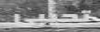

In [ ]:
img